# Introduction to MATLAB

## Section 3: A (very brief) introduction to machine learning

As mentioned in the Introduction, one of MATLAB's biggest strengths is its large collection of libraries and its abilities to get code up and running quickly.  As an example, we will perform some basic machine learning with `alexnet`, a neural network that is part of the Neural Network Toolbox.

The Neural Network toolbox doesn't come installed in the base MATLAB installation, so to use `alexnet`, you need to install it.  The easiest way to do it is to just type `alexnet` into your console and follow the instructions:

![First try!](../images/install_alexnet.png)

Once you install it and type `alexnet` again, you'll get a message like the one below.  Install that one too.  

![Second try!](../images/install_alexnet_2.png)

Now, this time, when you type in `alexnet`, you'll see the following.

![Third try!](../images/install_alexnet_3.png)

Great!  You're ready to go!

### Section 3.1: Making predictions

`alexnet` is a neural network that's been trained on hella images and is made to classify images into 1000 different categories.  It takes as input a 227 by 227 pixel image and attempts to classify that image into one of those 1000 categories.  To demonstrate how to work with `alexnet` (and neural networks in general), load in `../data/images/examples/ex1.jpg` and view the image:

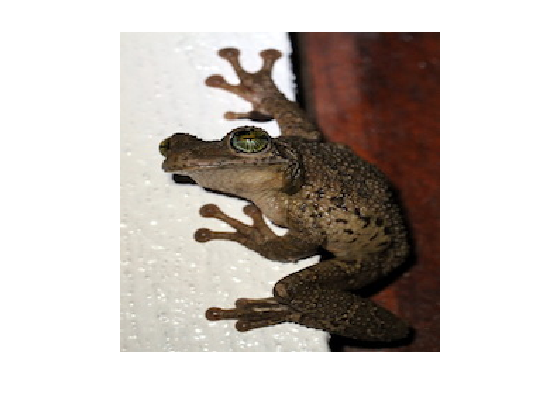

In [3]:
img1 = imread('../data/images/examples/ex1.jpg');
imshow(img1)

Now we're going to load in the `alexnet` neural network and save it to the variable `cnn`:

In [ ]:
format compact
cnn = alexnet

cnn = 
  SeriesNetwork with properties:

    Layers: [25x1 nnet.cnn.layer.Layer]


Now that we have the a neural network loaded, we can use the `classify` method to make a prediction about what the image is.  `classify` takes as arguments `net` and `img`, where `net` is the neural network being used to classify the image `img`.  

Let's see what `cnn` thinks our image `img1` is:

In [85]:
img1_pred = classify(cnn, img1)

img1_pred = 
  categorical
     bullfrog 


So `alexnet` thinks that `img1` is of a bullfrog.  Pretty good!  

How confident was `alexnet` in its prediction?  Like other functions we saw earlier, `classify` can actually output more than one value.  In this case, if we save the results of `classify` to `[prediction, score]`, we'll save the confidence `alexnet` has in its prediction to `score`.  For example, to save the prediction and confidence scores for `alexnet`'s prediction on our image, we can do (make sure to put the `;` at the end of the next line):

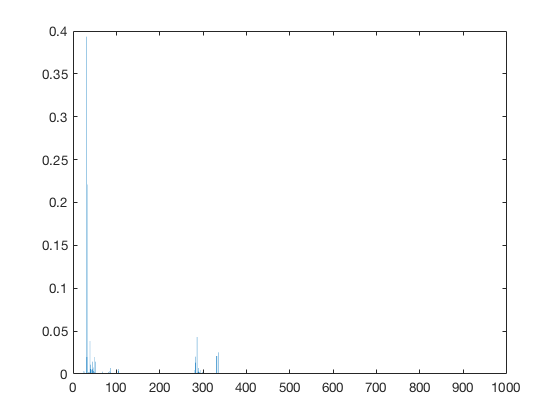

In [86]:
[img1_pred, img1_conf] = classify(cnn, img1);
bar(img1_conf)

There are a lot of really small numbers.  Why?

Let's fix this so that only the most "significant" predictions are indicated:

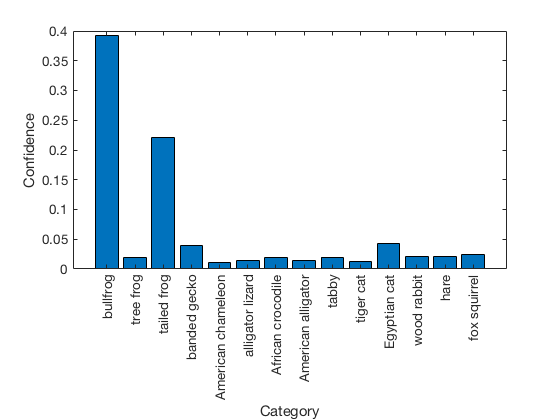

In [87]:
sig_threshold = 0.01;
sig_scores = img1_conf > sig_threshold;
bar(img1_conf(sig_scores))
categories = cnn.Layers(end).ClassNames;
xticklabels(categories(sig_scores))
xtickangle(90)
xlabel("Category")
ylabel("Confidence")

So it looked like `alexnet` was pretty confident that it was some sort of frog.  All in all, a solid prediction.  Let's repeat the process on another image.  First, we'll create a function to repeat the analysis:

In [88]:
%%file high_confidence_predictions.m
function high_confidence_predictions(image_path, net)
%high_confidence_predictions: display a barchart of significant predictions
%image_path is a path to the image of interest
%net is a neural net
    img = imread(image_path);
    img = imresize(img, [227, 227]);
    [prediction, confidence] = classify(net, img);
    
    sig_threshold = 0.01;
    sig_scores = confidence > sig_threshold;
    bar(confidence(sig_scores))
    categories = net.Layers(end).ClassNames;
    xticklabels(categories(sig_scores))
    xtickangle(90)
    xlabel("Category", 'fontsize', 6)
    ylabel("Confidence")
    
    
end

Created file '/Users/pvillanueva13/Documents/Notebooks/p3.matlab.fall2018/notebooks/high_confidence_predictions.m'.


> In images.internal.initSize (line 71)
  In imshow (line 336)


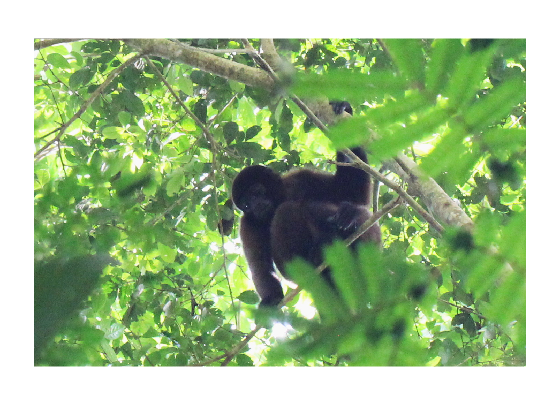

In [89]:
img2 = imread('../data/images/examples/ex2.jpg');
imshow(img2)

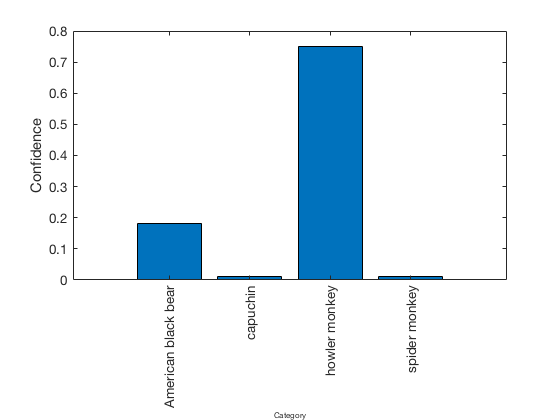

In [90]:
high_confidence_predictions('../data/images/examples/ex2.jpg', cnn)

This is a very confident prediction in two ways; the maximum prediction is quite strong and the predictions aren't spread over many categories.  Let's do one more example:

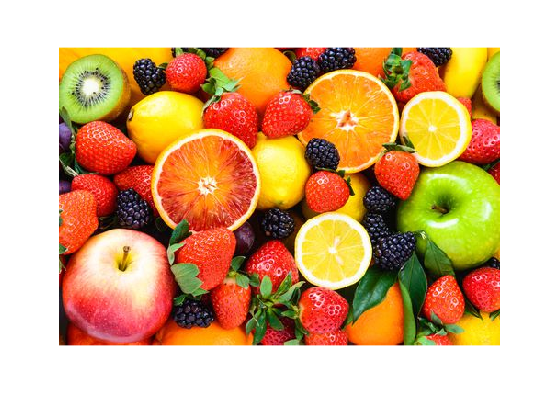

In [91]:
img3 = imread('../data/images/examples/ex3.jpg');
imshow(img3)

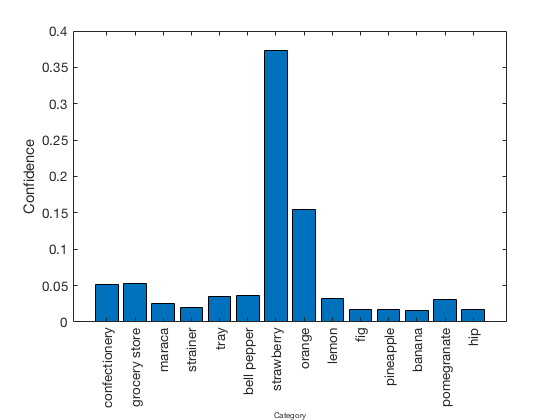

In [92]:
high_confidence_predictions('../data/images/examples/ex3.jpg', cnn)

What do you think?

#### Exercise 3.1

1. What do you think about the choice of a significance threshold?  How can we make it more statistically rigorous?  
2. Why do you think `alexnet`'s prediction on the second example was so much stronger than the prediction on the third example?  
3. Create the variable `in_layer = cnn.Layers(1)`.  Examine it.  What do the dimensions represent?
4. Repeat number 3 for `out_layer = cnn.Layers(end)`.  

### Section 3.2: Predictions on more than one image

As we talked about in the previous section, images can be pretty big, and keeping the image in memory can be a significant resource drain.  MATLAB provides a way of handling images in a more memory efficient way with `augmentedImageDatastore`.  Additionally, it will resize each of the pictures to fit into `alexnet`'s input layer:

In [ ]:
image_datastore = imageDatastore('../data/images/hummingbirds/*');
image_datastore.Files

From here, we could pass `image_datastore` to the `classify` function to classify all of the images with their corresponding confidence...

In [2]:
[predictions, confidences] = classify(cnn, image_datastore);

Error using eval
Undefined function or variable 'cnn'.



...or not.  What's wrong?

The input size of our images doesn't match the input layer of `alexnet`.  We can use `augmentedImageDatastore` to create resized versions of all the images in the `imageDatastore` so that we can use `alexnet`:

In [68]:
image_datastore_resized = augmentedImageDatastore([227 227], image_datastore);
[predictions, confidences] = classify(cnn, image_datastore_resized);

It worked!  Let's check out the predictions:  

In [69]:
predictions

predictions = 
  6x1 categorical array
     hummingbird 
     loupe 
     hummingbird 
     hummingbird 
     hummingbird 
     hummingbird 


We expected the neural net to classify each of the pictures as containing a hummingbird, but one of them was classified as a loupe.  Let's see what the image is of:

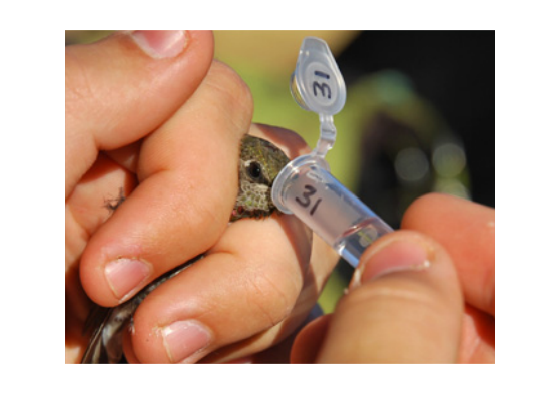

In [74]:
img4 = imread(image_datastore.Files{2});
imshow(img4)

Looking at the picture, we can certainly see why the prediction was so difficult.  let's use `high_confidence_predictions` to see what the significant predictions were from `alexnet`:

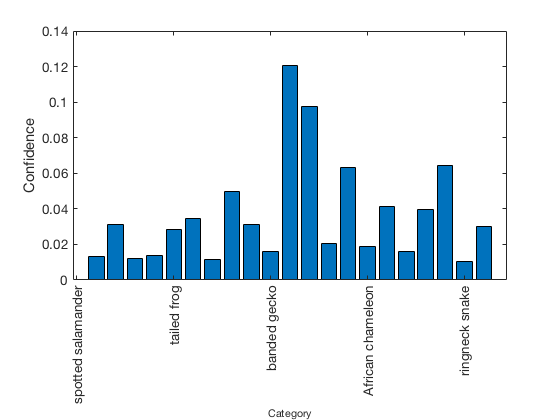

In [82]:
high_confidence_predictions(image_datastore.Files{2}, cnn)

`alexnet`'s predictions were all over the place and all pretty crappy.

### Section 3.3: Learning more about neural nets

Most biologists will only use neural nets (and machine learning in general) as black boxes, not bothering to learn more about how they work.  And that will be fine for most use cases - as demonstrated here, there are a lot of excellent resources available to help you in your analysis.

However, when the stuff that is readily available online stops working, having a working knowledge of how neural networks work will help you overcome whatever obstacle you're facing.  Here are some resources to help you learn more about neural networks:

* [3Blue1Brown's excellet series of videos on neural networks][https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi] is the best place to start.  He does a great job of emphasizing the intuition behind the network without getting bogged down in too much detail.  If you only do one thing to learn more about neural networks, watch these videos.
* [MATLAB's Deep Learning Onramp][https://matlabacademy.mathworks.com/R2018a/portal.html?course=deeplearning] is a great hands-on tutorial for getting you started with machine learning. 
* If you're ready to start digging into the math behind neural networks, the [Wikipedia entry][https://en.wikipedia.org/wiki/Convolutional_neural_network] is a good place to get a high-level overview.  From there, Bishop's book [Pattern Recognition and Machine Learning][http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf] is where to go for a more thorough treatment of the material.

